**Source : https://www.kaggle.com/iabhishekofficial/mobile-price-classification**

# Importing Modules and Files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Modules needed
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, warnings
from collections import Counter
from scipy import stats as ss
from sklearn.utils import resample
from scipy.stats import skew, iqr
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Adjust cell width to enhance data display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ignores warning
warnings.filterwarnings("ignore")

# Read necessary files
data = pd.read_csv("/content/drive/My Drive/data/train.csv")
test = pd.read_csv("/content/drive/My Drive/data/test.csv")

print("Data structure :")
display(data.head(1))
print("Data length : ", len(data), " rows")

Data structure :


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1


Data length :  2000  rows


**Headers info**

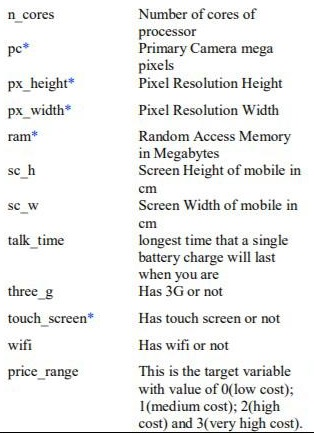

In [6]:
# Var info
from IPython.display import Image

Image(filename = "/content/drive/My Drive/data/info__.jpeg")
Image(filename = "/content/drive/My Drive/data/info_2_.jpeg")

# Business Problem

Bob has started his own mobile company. He wants to give tough fight to big companies like Apple, Samsung etc. He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market we cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies. He wants to find out some relation between features of a mobile phone (eg:- RAM, Internal Memory, etc) and its selling price.

# Goals

Find relation between features and the mobile price range through EDA and predict new data price range based on the best machine learning model.

# Variables Overview

In [7]:
# Data description
dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Variables description :")
desc = pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
])
display(desc)

Variables description :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Samples
0,battery_power,int64,0,0.0,1094,"[903, 744]"
1,blue,int64,0,0.0,2,"[0, 1]"
2,clock_speed,float64,0,0.0,26,"[1.8, 0.8]"
3,dual_sim,int64,0,0.0,2,"[1, 0]"
4,fc,int64,0,0.0,20,"[8, 18]"
5,four_g,int64,0,0.0,2,"[1, 0]"
6,int_memory,int64,0,0.0,63,"[9, 63]"
7,m_dep,float64,0,0.0,10,"[0.5, 0.9]"
8,mobile_wt,int64,0,0.0,121,"[144, 81]"
9,n_cores,int64,0,0.0,8,"[6, 8]"


**There's no missing values** in this dataset. Type of each variables also seems appropriate since they only contain float, binary, and category (int).

# Distribution, Outliers, and Correlation

In [8]:
# Defines formulas to check association
def correlation_ratio(categories, measurement):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measure = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measure)
        y_avg_array[i] = np.average(cat_measure)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurement, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurences
        p_y = y_counter[xy[1]] / total_occurences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else :
        return (s_x - s_xy) / s_x

In [9]:
# Quantitative report
print("Data quantitative report :")
display(data.describe())

Data quantitative report :


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


The data seems quite perfect. There's no indication of outliers if we look at the value gap between Q1 - min and Q3 - max. But, for further checking we will look deeper to each features distribution and also their correlation / association with target (price range).

In [10]:
# Correlation / association of each column
temp = []
for i in desc[:-1].index:
    if desc.Unique[i] == 2:
        temp.append({"Column" : desc['Columns Name'][i], "Value" : round(theils_u(data[desc['Columns Name'][i]], data['price_range']), 5), "" : "Theils U"})
    else:
        temp.append({"Column" : desc['Columns Name'][i], "Value" : round(correlation_ratio(data['price_range'], data[desc['Columns Name'][i]]), 5), "" : "Correlation Ratio"})

print("Correlation / association value of each column :")
display(pd.DataFrame(temp).sort_values("Value", ascending = False).reset_index().drop("index", 1))

Correlation / association value of each column :


,Column,Value,
0,ram,0.91708,Correlation Ratio
1,battery_power,0.21293,Correlation Ratio
2,px_width,0.18133,Correlation Ratio
3,px_height,0.16868,Correlation Ratio
4,mobile_wt,0.07330,Correlation Ratio
5,int_memory,0.06614,Correlation Ratio
6,n_cores,0.06269,Correlation Ratio
7,sc_h,0.05775,Correlation Ratio
8,sc_w,0.05005,Correlation Ratio
9,talk_time,0.04942,Correlation Ratio


We will only focus on top 10 highest value. This such **feature selection** will help us to determine which variables that have best impact on price range and thus maximize the model. 

In [11]:
# Checking anomaly
print("Column non - binary that have 0 as value :\n")
for i in data.drop("price_range", 1).columns:
    if len(data[i].unique()) > 2:
        if 0 in data[i].unique():
            print(i)

Column non - binary that have 0 as value :

fc
pc
px_height
sc_w


But, we found data anomaly in 4 columns and one of them is screen width (top 10 highest value). They have 0 as their value. 0 in front camera and primary camera can make any sense, since it indicates absence of front and primary camera itself. The non sense part is it also appears in pixel height and screen width. It's impossible for a mobile phone having no pixel height and screen width. So, we will fill the screen width with screen width average of all mobile in their price range. Meanwhile we won't handle pixel height since it's not in our features priority.

In [12]:
# Replacing 0 in screen width with their average
print("Total data that have 0 cm screen width : ", len(data[data["sc_w"] == 0]), " data")

for i in data[data["sc_w"] == 0].index:
    avg = round(np.mean(data[data["price_range"] == data["price_range"][i]]["sc_w"]), 0)
    data["sc_w"][i] = avg

Total data that have 0 cm screen width :  180  data


In [13]:
# New structure
data = data.drop(["m_dep", "pc", "fc", "clock_speed", "touch_screen", "four_g", "three_g", "blue", "dual_sim", "wifi"], 1)

print("New data structure :")
display(data.head(1))

New data structure :


,battery_power,int_memory,mobile_wt,n_cores,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,7,188,2,20,756,2549,9,7,19,1


Before jump in to the features, we'll check the target's distribution first.

## Price Range

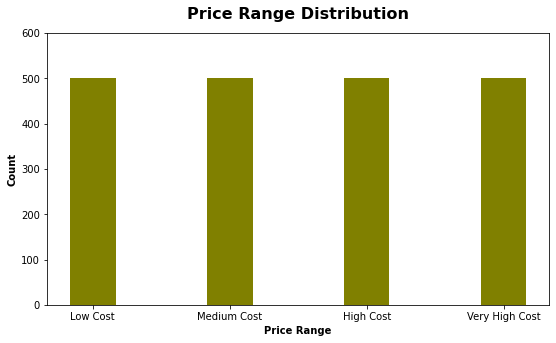

In [14]:
# Distribution
plt.figure(figsize = (9, 5))
plt.hist(data.price_range, color = "olive")
plt.ylim(0, 600)
plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))
plt.ylabel(
    "Count",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })
plt.title(
        "Price Range Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)

plt.show()

Each of price range category shares equal values count. This means the target have normal distribution and thus **balanced data**.

## Battery Power


Skewness value :  0.03


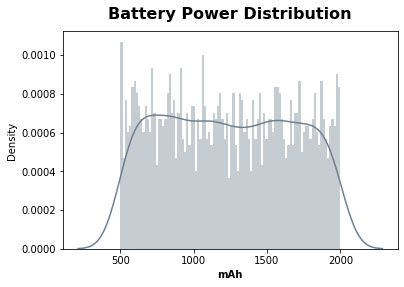

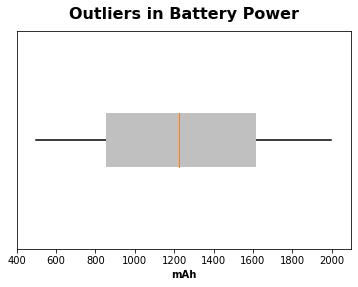

In [15]:
# Distribution
print("\nSkewness value : ", round(skew(data["battery_power"]), 2))

sns.distplot(data["battery_power"], bins = 100, color = "slategray")
plt.title(
        "Battery Power Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "mAh",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["battery_power"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Battery Power",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "mAh",
    fontdict = {"weight" : "bold"
    })
plt.xlim(400, 2100)

plt.show()

No outliers found in battery power. This indicates well distributed data (no mobile has significant long / short battery power). Skewness value also indicates normal distribution.

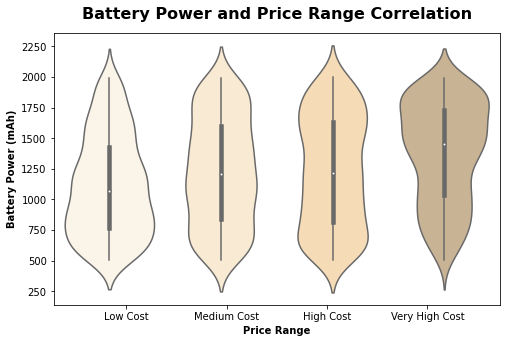

In [16]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["battery_power"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Battery Power and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Battery Power (mAh)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

Since it's an association between categorical and numerical data, it's better for us to use correlation ratio rather than Spearman or Pearson.

We can see clearly that increment in price also followed in increment of battery power. The majority of low cost mobile phone have around 500 - 1000 mAh while majority of very high cost mobile have around 1.300 - 1.900 mAh. But, turns out battery power has slight association when it comes to distinct medium cost and high cost mobile phone. This believed causes the correlation ratio value so small.

## Internal Memory


Skewness value :  0.03


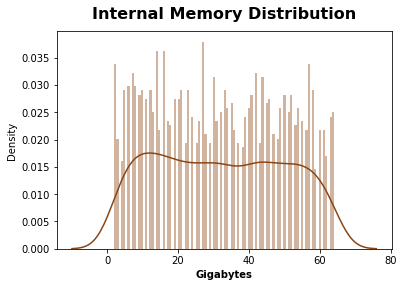

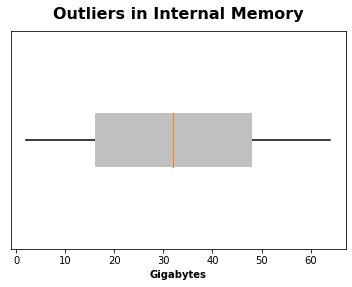

In [17]:
# Distribution
print("\nSkewness value : ", round(skew(data["battery_power"]), 2))

sns.distplot(data["int_memory"], bins = 100, color = "saddlebrown")
plt.title(
        "Internal Memory Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Gigabytes",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["int_memory"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Internal Memory",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Gigabytes",
    fontdict = {"weight" : "bold"
    })

plt.show()

Skewness value and KDE line indicates a very normal distribution. It also means internal memory have no outliers.

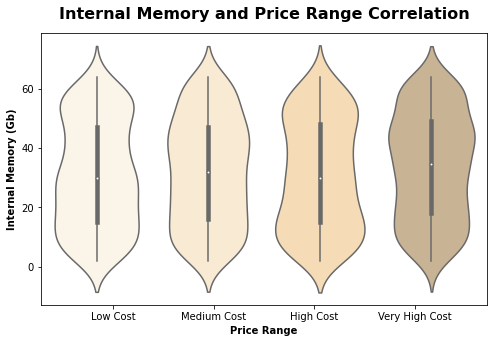


Internal memory average per price range :


,Internal Memory (GB)
Low Cost,31.174
Medium Cost,32.116
High Cost,30.920
Very High Cost,33.976


In [18]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["int_memory"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Internal Memory and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Internal Memory (Gb)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"int_memory" : "Internal Memory (GB)"})[["Internal Memory (GB)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nInternal memory average per price range :")
display(temp)

Looks like internal memory doesn't give enough impact to mobile price range. Violin plot shows us a slight difference between every range. If we look deeper, internal memory average per category only differ in very small value.

High cost mobile turns out have lower average than the medium cost. Looks like price increment from medium to high cost is based on other features like battery power or ram rather than internal memory.

## Mobile Weight


Skewness value :  0.01


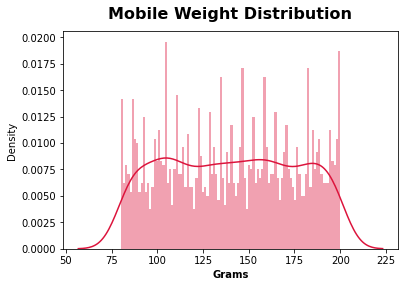

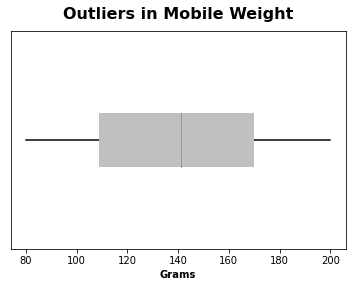

In [19]:
# Distribution
print("\nSkewness value : ", round(skew(data["mobile_wt"]), 2))

sns.distplot(data["mobile_wt"], bins = 100, color = "crimson")
plt.title(
        "Mobile Weight Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Grams",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["mobile_wt"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Mobile Weight",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Grams",
    fontdict = {"weight" : "bold"
    })

plt.show()

This feature also has a very normal distribution and no outliers, so no need to handle the values.

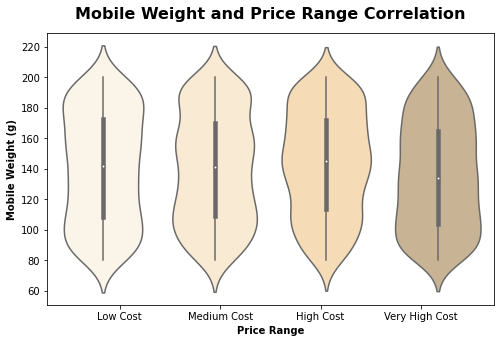


Mobile weight average per price range :


,Mobile Weight (g)
Low Cost,140.552
Medium Cost,140.510
High Cost,143.614
Very High Cost,136.320


In [20]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["mobile_wt"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Mobile Weight and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Mobile Weight (g)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"mobile_wt" : "Mobile Weight (g)"})[["Mobile Weight (g)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nMobile weight average per price range :")
display(temp)

Just like before, high cost mobile appears again as an inconsistent pattern of mobile price range. From the violin plot we see enlargement at higher weight value on high cost mobile, when on the other hand low - medium cost mobile enlarge in lower weight value. We also can conclude from their average, where very high cost mobile has the lowest / lightest weight.

## Number of Cores of Processor


Skewness value :  0.0036


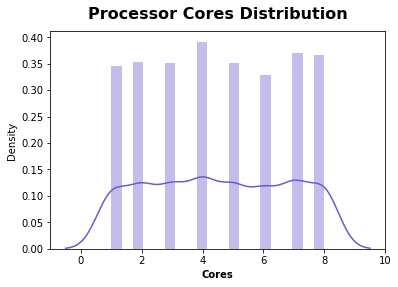

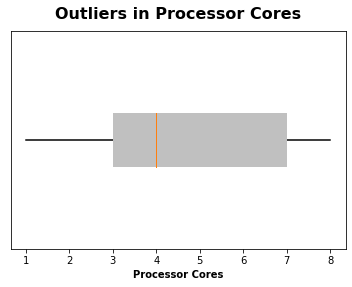

In [21]:
# Distribution
print("\nSkewness value : ", round(skew(data["n_cores"]), 4))

sns.distplot(data["n_cores"], bins = 20, color = "slateblue")
plt.title(
        "Processor Cores Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Cores",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["n_cores"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Processor Cores",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Processor Cores",
    fontdict = {"weight" : "bold"
    })

plt.show()

Number of processor cores are well distributed along the data. This means a normal distribution. But, shorter whisker at the upper fence indicates that number of cores tend to pile up on higher value.

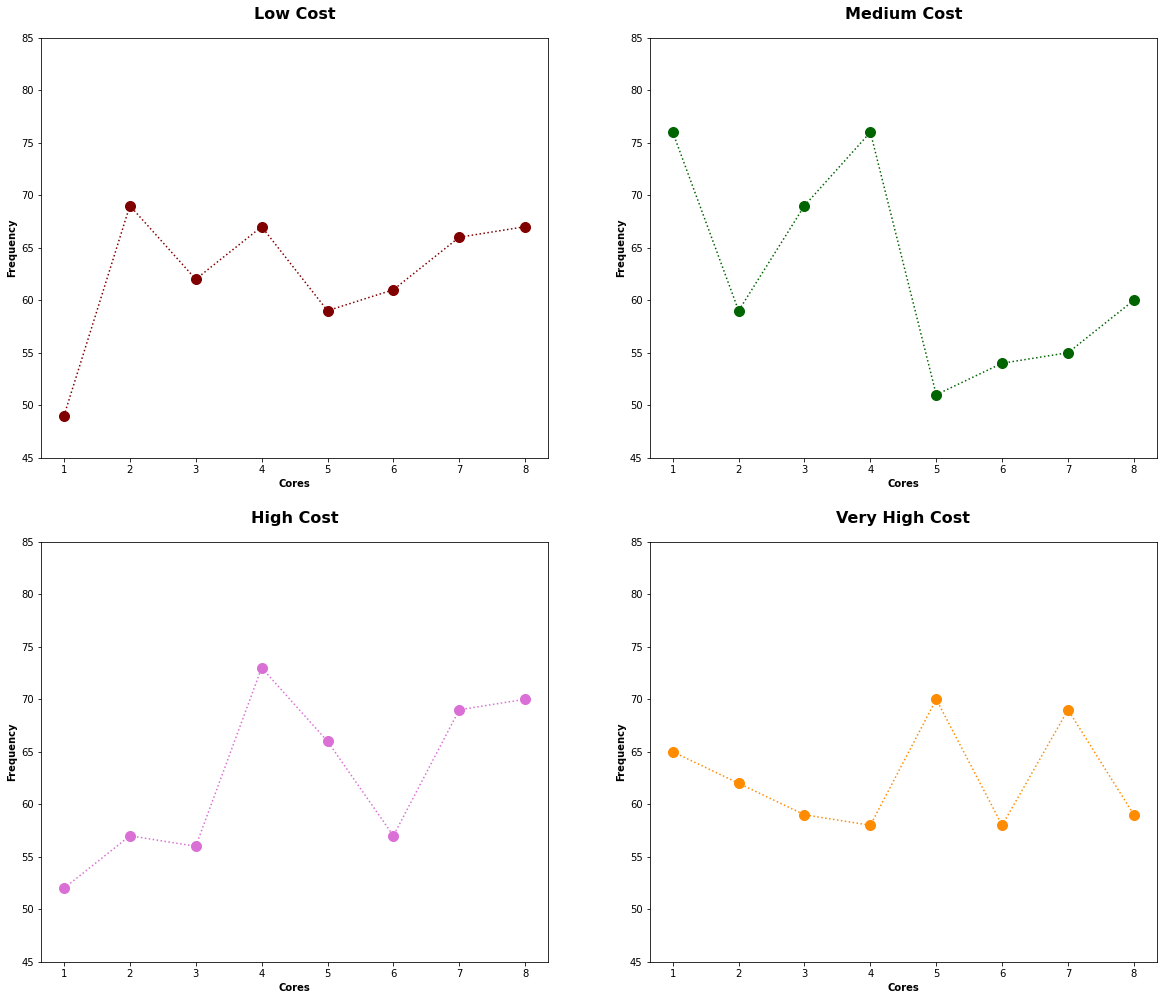

In [22]:
# Correlation
fig, axes = plt.subplots(2, 2, figsize = (20, 17))
temp, count, color, label = pd.crosstab(data["price_range"], data["n_cores"]), -1, ["maroon", "orchid", "darkgreen", "darkorange", "darkorange"], ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]

for row in axes:
    for cl, col in zip(color, row):
        count += 1
        col.plot(temp.loc[count], color = cl, linestyle = ":", marker = "o", markersize = 10)
        col.set_ylim(45, 85)
        col.set_title(
                label[count],
                fontdict = {"fontsize": 16,
                "fontweight" : "bold",
                "color" : "black",
                "verticalalignment": "baseline",
                "horizontalalignment": "center"
                },
                y = 1.03)
        col.set_xlabel(
            "Cores",
            fontdict = {"weight" : "bold"
            })
        col.set_ylabel(
            "Frequency",
            fontdict = {"weight" : "bold"
            })
        color.remove(cl)

Number of processor cores seems not linear to the price range. We can see that there's no pattern along the graph. For instance, 1 core (instead of decreasing when price is increasing) increases from high cost to very high cost. The maximum core (8 cores) also give us strange pattern. The frequency in very high cost is less than in low cost. It means that sophisticated and expensive mobile doesn't always equipped with sophisticated processor. On the other hand, cheaper mobile doesn't always equipped with out-of-date processor.

## Pixel Resolution Height


Skewness value :  0.6658


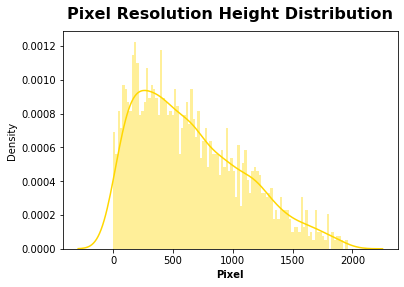

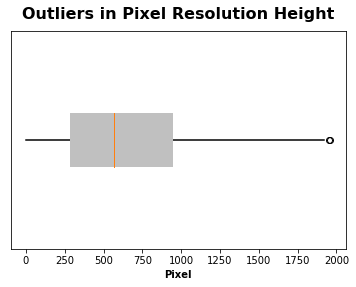

In [23]:
# Distribution
print("\nSkewness value : ", round(skew(data["px_height"]), 4))

sns.distplot(data["px_height"], bins = 100, color = "gold")
plt.title(
        "Pixel Resolution Height Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Pixel",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["px_height"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Pixel Resolution Height",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Pixel",
    fontdict = {"weight" : "bold"
    })

plt.show()

Skewness value indicates a moderate positive skewness and as a result shaped as a right skewed. This means pixel resolution height is moderatly centralized at the lower - middle value. Thus, significant high values become outliers, just like the boxplot tells us. Those outliers must be handled and elaborated to know how to handle it.

In [24]:
# Checking outliers
upperFence = np.percentile(data["px_height"], 75) + (1.5 * iqr(data["px_height"]))

print("Outlier in pixel resolution height :")
display(data[data["px_height"] > upperFence])

Outlier in pixel resolution height :


,battery_power,int_memory,mobile_wt,n_cores,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
988,1413,45,104,5,1949,1994,2973,17,8,15,3
1771,1230,48,111,7,1960,1963,1622,18,17,16,2


There's nothing to worry on these outliers. The data seem normal and nothing suspicious. I decided to keep the outliers since it won't affect the analysis and modelling process.

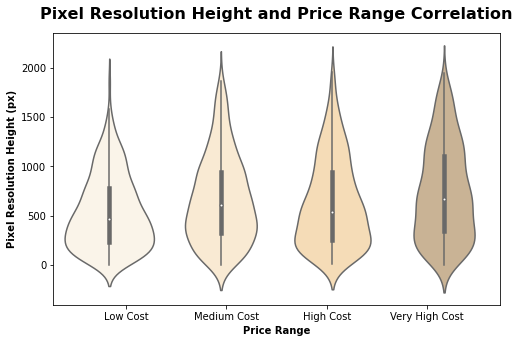


Pixel resolution height average per price range :


,Pixel Resolution Height (px)
Low Cost,536.408
Medium Cost,666.892
High Cost,632.284
Very High Cost,744.848


In [25]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["px_height"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Pixel Resolution Height and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Pixel Resolution Height (px)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"px_height" : "Pixel Resolution Height (px)"})[["Pixel Resolution Height (px)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nPixel resolution height average per price range :")
display(temp)

Pixel resolution height doesn't give enough impact to mobile price range, specifically for high cost mobile. The above plot shows us a consistent pattern from low to medium cost, and also for very high cost that has the highest pixel resolution height. Size of the lower value decreases along the price increment. But, it turns out that the high cost mobile have lower pixel resolution height than the medium cost on average. Looks like pixel resolution height isn't that important for high cost mobile.

## Pixel Resolution Width


Skewness value :  0.0148


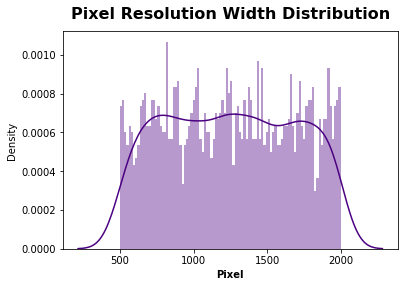

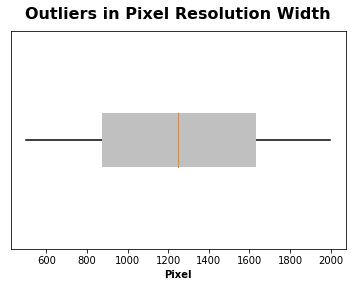

In [26]:
# Distribution
print("\nSkewness value : ", round(skew(data["px_width"]), 4))

sns.distplot(data["px_width"], bins = 100, color = "indigo")
plt.title(
        "Pixel Resolution Width Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Pixel",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["px_width"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Pixel Resolution Width",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Pixel",
    fontdict = {"weight" : "bold"
    })

plt.show()

This feature has a normal distribution and no outliers. Nothing to worry about.

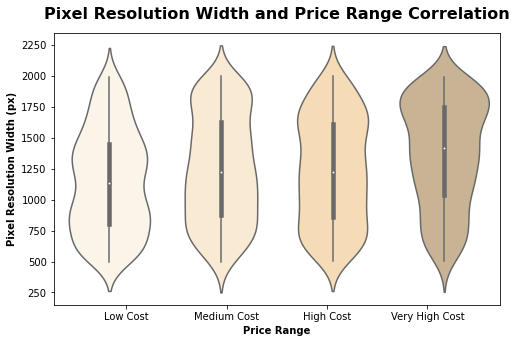


Pixel resolution width average per price range :


,Pixel Resolution Width (px)
Low Cost,1150.270
Medium Cost,1251.908
High Cost,1234.046
Very High Cost,1369.838


In [27]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["px_width"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Pixel Resolution Width and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Pixel Resolution Width (px)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"px_width" : "Pixel Resolution Width (px)"})[["Pixel Resolution Width (px)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nPixel resolution width average per price range :")
display(temp)

It's an identical condition like pixel resolution height. So, it seems like pixel resolution width also isn't that important for high cost mobile.

## RAM


Skewness value :  0.0066


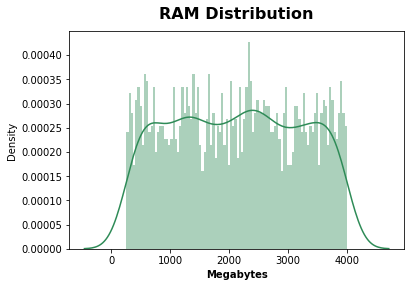

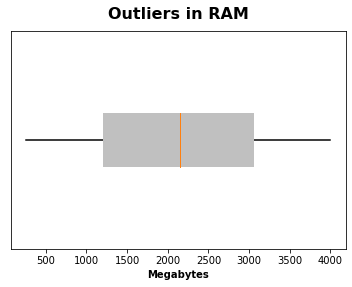

In [28]:
# Distribution
print("\nSkewness value : ", round(skew(data["ram"]), 4))

sns.distplot(data["ram"], bins = 100, color = "seagreen")
plt.title(
        "RAM Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Megabytes",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["ram"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in RAM",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Megabytes",
    fontdict = {"weight" : "bold"
    })

plt.show()

This feature has a normal distribution and no outliers. Nothing to worry about.

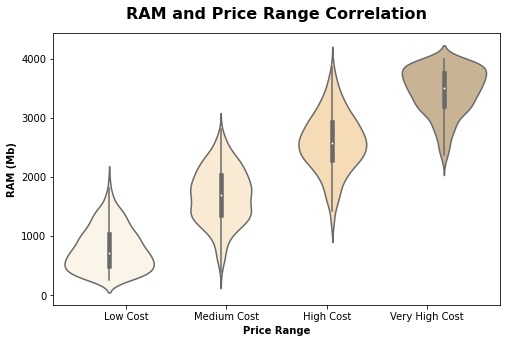


RAM average per price range :


,RAM (Mb)
Low Cost,785.314
Medium Cost,1679.490
High Cost,2582.816
Very High Cost,3449.232


In [29]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["ram"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "RAM and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "RAM (Mb)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"ram" : "RAM (Mb)"})[["RAM (Mb)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nRAM average per price range :")
display(temp)

RAM has very high linear correlation with price range. The plot explicitly shows us that the higher the mobile price is, the higher the RAM is also. This means that one of the determinant factors to specify mobile price is RAM.

## Screen Height


Skewness value :  -0.0988


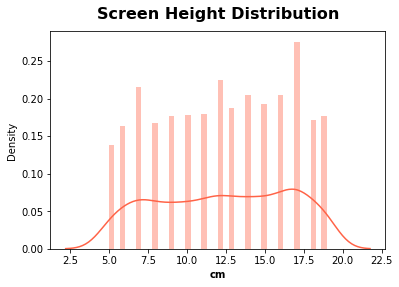

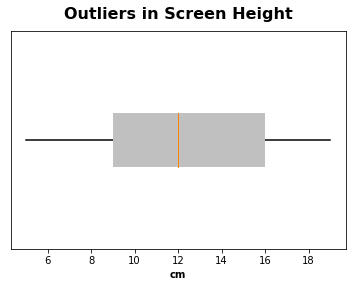

In [30]:
# Distribution
print("\nSkewness value : ", round(skew(data["sc_h"]), 4))

sns.distplot(data["sc_h"], bins = 40, color = "tomato")
plt.title(
        "Screen Height Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "cm",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["sc_h"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Screen Height",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "cm",
    fontdict = {"weight" : "bold"
    })

plt.show()

This feature has a normal distribution and no outliers, but a very slight centralization at the higher value. Overall, nothing to worry about.

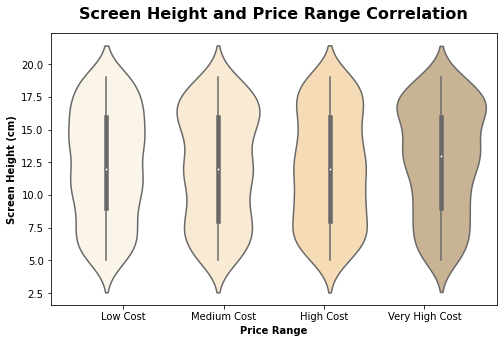


Screen height average per price range :


,Screen Height (cm)
Low Cost,12.324
Medium Cost,12.212
High Cost,12.010
Very High Cost,12.680


In [31]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["sc_h"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Screen Height and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Screen Height (cm)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"sc_h" : "Screen Height (cm)"})[["Screen Height (cm)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nScreen height average per price range :")
display(temp)

It turns out that the higher the price is, the shorter the mobile screen is. But, this only applied between low - high cost mobile. Very high cost mobile on the other hand has the longest screen height. It can be concluded that screen height doens't seem so impactful to determine mobile price.

## Screen Width


Skewness value :  0.7055


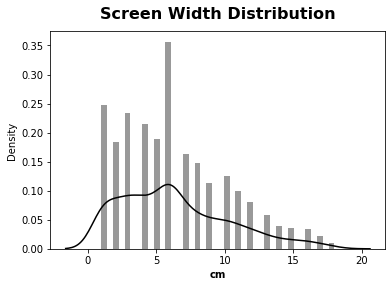

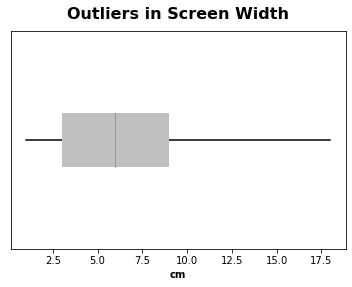

In [32]:
# Distribution
print("\nSkewness value : ", round(skew(data["sc_w"]), 4))

sns.distplot(data["sc_w"], bins = 40, color = "black")
plt.title(
        "Screen Width Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "cm",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["sc_w"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Screen Width",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "cm",
    fontdict = {"weight" : "bold"
    })

plt.show()

Skewness value indicates a moderate positive skewness and as a result shaped as a right skewed. This means screen width is moderatly centralized at the lower - middle value, especially between 6 - 7 cm. Boxplot with short whisker at the lower fence also shows the same result. Unlike pixel resolution height, this feature has no outliers.

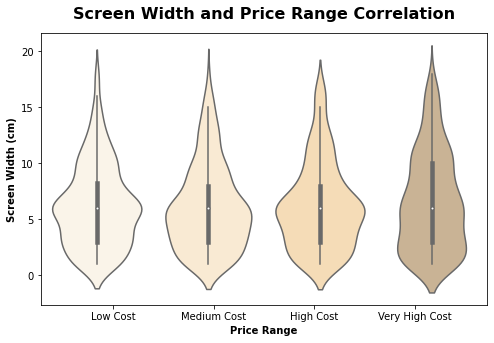


Screen width average per price range :


,Screen Width (cm)
Low Cost,6.270
Medium Cost,6.120
High Cost,6.242
Very High Cost,6.610


In [33]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["sc_w"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Screen Width and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Screen Width (cm)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"sc_w" : "Screen Width (cm)"})[["Screen Width (cm)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nScreen width average per price range :")
display(temp)

Screen width doesn't provide pattern to determine mobile price. Medium cost mobile has more narrow screen than low cost mobile, but high cost mobile has wider screen than medium. Just like screen height, screen width also doens't seem so impactful to determine mobile price.

## Talk Time


Skewness value :  0.0095


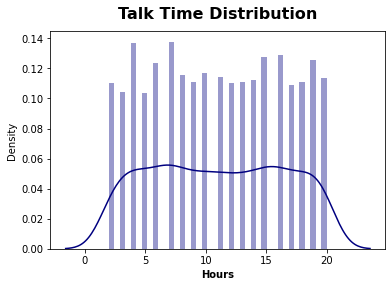

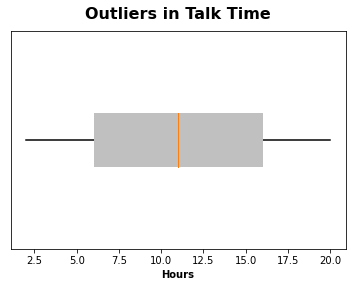

In [34]:
# Distribution
print("\nSkewness value : ", round(skew(data["talk_time"]), 4))

sns.distplot(data["talk_time"], bins = 40, color = "navy")
plt.title(
        "Talk Time Distribution",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.xlabel(
    "Hours",
    fontdict = {"weight" : "bold"
    })

plt.show()

# Outliers
plt.boxplot(
            data["talk_time"],
            widths = 0.25,
            vert = False,
            boxprops = {
                "facecolor" : "silver",
                "linewidth" : 0,
                "color" : "darkgoldenrod"
            },
            patch_artist = True,
            whiskerprops = {
                "ls": "solid",
                "lw": 1.5,
                "color": "black"
            },
            showcaps = False)
plt.title(
        "Outliers in Talk Time",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.yticks([])
plt.xlabel(
    "Hours",
    fontdict = {"weight" : "bold"
    })

plt.show()

This feature has a normal distribution and no outliers. Nothing to worry about.

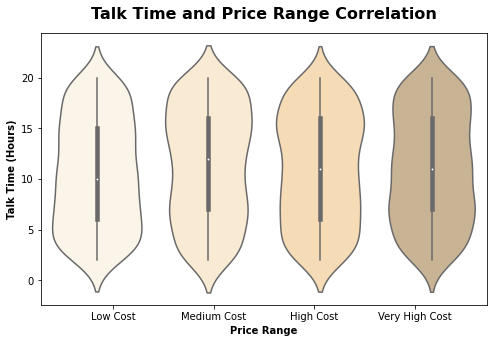


Talk time average per price range :


,Talk Time (Hours)
Low Cost,10.612
Medium Cost,11.362
High Cost,10.972
Very High Cost,11.098


In [35]:
# Correlation
plt.figure(figsize = (8, 5))
sns.violinplot(data["price_range"], data["talk_time"], palette = ["oldlace", "blanchedalmond", "navajowhite", "tan"])
plt.title(
        "Talk Time and Price Range Correlation",
        fontdict = {"fontsize": 16,
        "fontweight" : "bold",
        "color" : "black",
        "verticalalignment": "baseline",
        "horizontalalignment": "center"
        },
        y = 1.03)
plt.ylabel(
    "Talk Time (Hours)",
    fontdict = {"weight" : "bold"
    })
plt.xlabel(
    "Price Range",
    fontdict = {"weight" : "bold"
    })

plt.xticks((0.15, 1.05, 1.95, 2.85), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))

plt.show()

temp = data.groupby(data["price_range"]).mean().rename(columns = {"talk_time" : "Talk Time (Hours)"})[["Talk Time (Hours)"]]
temp.index.name = "Price Range"
temp.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
print("\nTalk time average per price range :")
display(temp)

Higher mobile price doesn't always give us a good battery lifetime (single charge). It does make sense because sophisticated mobile tend to have many and newest features from the industry. Hence the battery consumption decreases. There's slight difference in average between high and very high cost mobile. Most likely, even the highest mobile cost have the most advanced features and technology, it also equipped with better battery lifetime than high cost mobile. However, still it can't compete with medium cost mobile lifetime (that has fewer features and so-last-year technology).

# Modelling

## Base Model

Base Model is used to see potential algorithms. Later, only those potentials will be tuned to maximazie the model.

### Preparation

In [37]:
# Splitting Data
X = data.drop("price_range", 1)
y = data["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 7)

In [ ]:
# Algorithms
# Logistic Regression
LogReg = LogisticRegression().fit(X_train, y_train)
LogRegPredTest = LogReg.predict(X_test)

# Random Forest Classifier
RanFor = RandomForestClassifier().fit(X_train, y_train)
RanForPredTest = RanFor.predict(X_test)

# Support Vector Machine Classifier
SVM = SVC().fit(X_train, y_train)
SVMPredTest = SVM.predict(X_test)

# K - Nearest Neighbors Classifier
KNN = KNeighborsClassifier().fit(X_train, y_train)
KNNPredTest = KNN.predict(X_test)

# Extreme Gradient Boosting Classifier
XGB = XGBClassifier().fit(X_train, y_train)
XGBPredTest = XGB.predict(X_test)

# Decission Tree Classifier
DT = DecisionTreeClassifier().fit(X_train, y_train)
DTPredTest = DT.predict(X_test)

# AdaBoost Classifier
AdaB = AdaBoostClassifier().fit(X_train, y_train)
AdaBPredTest = AdaB.predict(X_test)

# Gradient Boosting Classifier
GB = GradientBoostingClassifier().fit(X_train, y_train)
GBPredTest = GB.predict(X_test)

### Evaluation Metrics

Since the data is balanced, we can use accuracy to evaluate the models.

In [ ]:
# Accuracy
LogRegAcc = accuracy_score(y_test, LogRegPredTest)
RanForAcc = accuracy_score(y_test, RanForPredTest)
SVMAcc = accuracy_score(y_test, SVMPredTest)
KNNAcc = accuracy_score(y_test, KNNPredTest)
XGBAcc = accuracy_score(y_test, XGBPredTest)
DTAcc = accuracy_score(y_test, DTPredTest)
AdaBAcc = accuracy_score(y_test, AdaBPredTest)
GBAcc = accuracy_score(y_test, GBPredTest)

print("Accuracy score for each base models :")
display(pd.DataFrame(
    {"Accuracy" : [LogRegAcc, RanForAcc, SVMAcc, KNNAcc, XGBAcc, DTAcc, AdaBAcc, GBAcc]},
    index = ["LogReg", "RanFor", "SVM", "KNN", "XGB", "DT", "AdaBoost", "GradientBoost"]).sort_values("Accuracy", ascending = False)
  )

Accuracy score for each base models :


,Accuracy
SVM,0.9550
XGB,0.9250
RanFor,0.9175
KNN,0.9125
GradientBoost,0.9125
DT,0.8200
AdaBoost,0.7000
LogReg,0.6375


We pick only top 3 models to be tuned. **SVM**, **XGBoost**, and **Random Forest** are the most potential algorithms.

## Tuned Model

### SV Classifier

#### Scaling

In [38]:
# Using MinMax Scaler
XScaled = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, stratify = y, test_size = .2, random_state = 7)

SVM = SVC().fit(X_train, y_train)
SVMPredTest = SVM.predict(X_test)

print("Classification report of scaled SVM:\n")
print(classification_report(y_test, SVMPredTest))

Classification report of scaled SVM:

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       100
           1       0.92      0.89      0.90       100
           2       0.94      0.92      0.93       100
           3       0.99      0.96      0.97       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



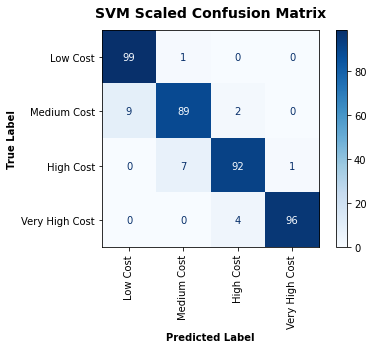

In [39]:
# Confusion Matrix
cm = plot_confusion_matrix(SVM, X_test, y_test, cmap = plt.cm.Blues, values_format = "g")
plt.xticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"), rotation = 90)
plt.yticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))
plt.xlabel("Predicted Label", fontdict = {"weight" : "bold"})
plt.ylabel("True Label", fontdict = {"weight" : "bold"})
cm.ax_.set_title("SVM Scaled Confusion Matrix", fontdict = {"weight" : "bold", "size" : 14}, y = 1.03)

plt.show()

Overall, scaled SVM produce good evaluation metrics. In this context, we focus on recall rather than precision because reducing **false negative** will save the seller from loss. Take an example of Samsung S8+. In actual it costs around 200 USD (medium cost), but our machine predicts it around 130 USD (low cost). Can we imagine how much loss the seller would get?

Thus we put recall of every class on our concern. The scaled SVM seems good but need an improvement for medium cost mobile. We can see that it has the biggest error from the others.

Honestly, medium and high cost mobile don't have clear difference. EDA shows us the two classes sometimes overlap each other. So error in predicting high cost to medium cost - vice versa - can be tolerated. On the other hand, error in predicting high cost to very hight cost can't be tolerated. Thus this model needs another improvement to minimize the error.

#### Hyper Parameter Tuning

We use GridSearchCV instead of RandomizedSearchCV because:
- Number of data isn't that large, so we still can catch up time efficiency.
- GridSearchCV produce better results.

**Source : https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85**

In [40]:
# Tuning from scaled X
SVMTuned = GridSearchCV(
    estimator = SVC(),
    param_grid = {
    "C" : [1, 0.1, 5, 0.5, 10],
    "kernel" : ["rbf", "linear"],
    "gamma" : ["scale", "auto", 1, 1.5, 0.5],
    "max_iter" : [100, 300, 500]
    }, cv = 5,
    n_jobs = -1,
    verbose = 1)

SVMTuned.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   30.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 0.1, 5, 0.5, 10],
                         'gamma': ['scale', 'auto', 1, 1.5, 0.5],
                         'kernel': ['rbf', 'linear'],
                         'max_iter': [100, 300, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

Classification report of tuned SVM :

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       100
           1       0.95      0.93      0.94       100
           2       0.97      0.95      0.96       100
           3       0.99      0.99      0.99       100

    accuracy                           0.96       400
   macro avg       0.97      0.97      0.96       400
weighted avg       0.97      0.96      0.96       400
 



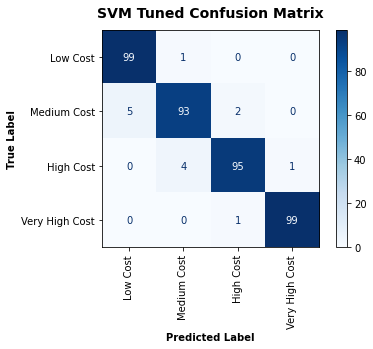

In [41]:
# Evaluation Metrics
bestSVMTuned = SVMTuned.best_estimator_
bestSVMTunedPredTest = bestSVMTuned.predict(X_test)

print("Classification report of tuned SVM :\n")
print(classification_report(y_test, bestSVMTunedPredTest), "\n")

# Confusion Matrix
cm = plot_confusion_matrix(bestSVMTuned, X_test, y_test, cmap = plt.cm.Blues, values_format = "g")
plt.xticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"), rotation = 90)
plt.yticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))
plt.xlabel("Predicted Label", fontdict = {"weight" : "bold"})
plt.ylabel("True Label", fontdict = {"weight" : "bold"})
cm.ax_.set_title("SVM Tuned Confusion Matrix", fontdict = {"weight" : "bold", "size" : 14}, y = 1.03)

plt.show()

We can see that the **tuned - scaled SVM** has the best result. Recall value for medium cost mobile increases significantly to 0.93. Also, the machine 99% succeed to predict very high cost mobile correctly. The number of error for each class also decreases. Hence, this is the best SVM model.

### XGB Classifier

Since XGB is a tree based algorithm, scaling won't take any effect to the result. Hence we jump in to hyper parameter tuning.

In [ ]:
# Splitting Data
X = data.drop("price_range", 1)
y = data["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 7)

In [ ]:
# Tuning from X
XGBTuned = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = {
    "max_depth" :  [3, 6, 9],
    "learning_rate" : [.3, .5, .7],
    "n_estimator" : [100, 300, 500],
    "gamma" : [0, 0.3, 0.7],
    "colsample_bytree" : [.3, .5, .7],
    "reg_alpha" : [0, .5],
    "reg_lambda" : [.5, 1]
    }, cv = 3,
    n_jobs = -1,
    verbose = 1)

XGBTuned.fit(X_train, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed: 11.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'gamma': [0, 0.3, 0.7],
                         'learning_rate': [0.3, 0.5, 0.7],
         

Classification report of tuned XGB :

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       100
           1       0.90      0.87      0.88       100
           2       0.94      0.89      0.91       100
           3       0.96      0.98      0.97       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400
 



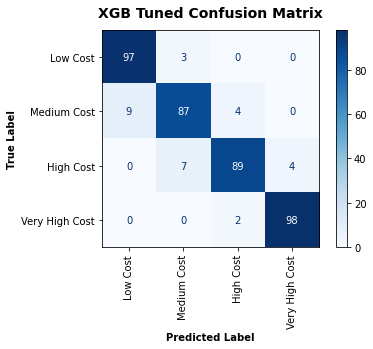

In [ ]:
# Evaluation Metrics
bestXGBTuned = XGBTuned.best_estimator_
bestXGBTunedPredTest = bestXGBTuned.predict(X_test)

print("Classification report of tuned XGB :\n")
print(classification_report(y_test, bestXGBTunedPredTest), "\n")

# Confusion Matrix
cm = plot_confusion_matrix(bestXGBTuned, X_test, y_test, cmap = plt.cm.Blues, values_format = "g")
plt.xticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"), rotation = 90)
plt.yticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))
plt.xlabel("Predicted Label", fontdict = {"weight" : "bold"})
plt.ylabel("True Label", fontdict = {"weight" : "bold"})
cm.ax_.set_title("XGB Tuned Confusion Matrix", fontdict = {"weight" : "bold", "size" : 14}, y = 1.03)

plt.show()

Tuned XGBoost Classifier turns out not as good as tuned SVM.

### Random Forest Classifier

Same as XGB, Random Forest doesn't need scaling to maximize its model. Hence we jump in to Hyper Parameter Tuning.

In [ ]:
# Tuning from X
RanForTuned = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = {
        "n_estimators" : [100, 300, 500],
        "max_depth" : [None, 5, 7, 9],
        "min_samples_split" : [5, 15, 25],
        "min_samples_leaf" : [2, 7, 10],
        "max_features" : ["auto", .3, .5],
        "min_impurity_decrease" : [0, 0.5, 0.7]
        }, cv = 3, n_jobs = -1, verbose = 1
    )

RanForTuned.fit(X_train, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed: 24.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Classification report of tuned Random Forest :

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       100
           1       0.87      0.83      0.85       100
           2       0.93      0.88      0.90       100
           3       0.97      0.98      0.98       100

    accuracy                           0.92       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.92      0.91       400
 



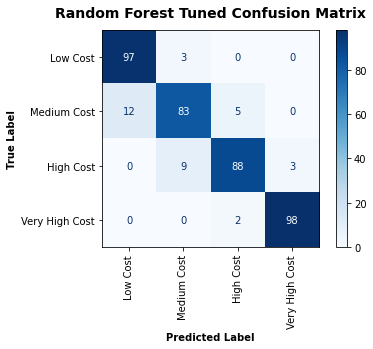

In [ ]:
# Evaluation Metrics
bestRanForTuned = RanForTuned.best_estimator_
bestRanForTunedPredTest = bestRanForTuned.predict(X_test)
bestRanForTunedPredTrain = bestRanForTuned.predict(X_train)

print("Classification report of tuned Random Forest :\n")
print(classification_report(y_test, bestRanForTunedPredTest), "\n")

# Confusion Matrix
cm = plot_confusion_matrix(bestRanForTuned, X_test, y_test, cmap = plt.cm.Blues, values_format = "g")
plt.xticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"), rotation = 90)
plt.yticks((0, 1, 2, 3), ("Low Cost", "Medium Cost", "High Cost", "Very High Cost"))
plt.xlabel("Predicted Label", fontdict = {"weight" : "bold"})
plt.ylabel("True Label", fontdict = {"weight" : "bold"})
cm.ax_.set_title("Random Forest Tuned Confusion Matrix", fontdict = {"weight" : "bold", "size" : 14}, y = 1.03)

plt.show()

This model is worse than tuned XGB, but just a slight different error rates in high cost mobile. Tuned Random Forest is better in predicting high cost mobile since it only fail to predict 3 mobiles rather than tuned XGB did (4 mobiles). On the other hand, it fails to predict more to medium cost mobile.

However, we can tolerate error from high cost to medium cost - vice versa - because the difference isn't clear, but error in predicting very high cost to  high cost will most likely gain more loss to seller. 

# Predicton

In [64]:
# Re - structuring test data to the same train data structure
testId = test[["id"]]
test.drop(["id", "m_dep", "pc", "fc", "clock_speed", "touch_screen", "four_g", "three_g", "blue", "dual_sim", "wifi"], 1, inplace = True)
testScaled = MinMaxScaler().fit_transform(test)

In [65]:
# Predictiong using tuned - scaled SVM (best model)
testPred = bestSVMTuned.predict(testScaled)
testId["price_range_prediction"] = testPred

In [71]:
# Result
print("Predicted price range :")
result = testId.groupby("price_range_prediction").count().rename(
    columns = {
        "id" : "Count"
    }
)
result.index.name = "Predicted Price Range"
result.index = ["Low Cost", "Medium Cost", "High Cost", "Very High Cost"]
display(result)

Predicted price range :


,Count
Low Cost,254
Medium Cost,233
High Cost,251
Very High Cost,262


# Conclusion and Recommendation
- Medium cost and high cost mobile don't differ very much. Instead, on some features they overlap each other. This means if the machine failed to predict between those two categories (predict high to medium), company won't suffer loss that much.
- It's quite easy to distinguish very high cost mobiles from another. Almost all features they have are the biggest (except mobile weight --the lighthest), except number of cores and talk time. Their talk time is still lower than medium cost mobile. This is make senses since more advanced technology result in more battery consumption.
- RAM and battery power are the only determinant factors, which successfully distinguish every single mobile cost categories in linear pattern.
- Tuned and scaled SVM Classifier is the best model we can get so far. It has the minimum error rate and the highest recall score. Thus, this model can bring the most minimum loss and the most maximum profit from predicting new mobile data.
- Bob, the company owner, should be happy because his dream of fighting against Apple and Samsung seems realistic. From the predicted mobile price range, the very high cost mobiles took 26,2% proportion of all predicted data (all categories seems even, but very high cost mobile has the highest percentage). This means Bob's highest quality mobile devices are close enough to existing manufacture's highest standard quality.
- Medium cost mobile has the lowest proportion of predicted data. But, it's suggested for Bob to merge medium and high cost mobiles into one category / price range. As stated above, because of thin border of differentiation of those two categories, Bob will most likely have slight profit loss (assumed if Bob sells high cost mobile with medium cost mobile's price) since we focus on **decreasing error on very high cost mobiles** rather than **medium - high cost mobiles**.